In [21]:
import pandas as pd

def smooth_velocity_by_player(df, window=5):
    """
    Suaviza as colunas 'vx', 'vy' e 'speed' usando média móvel,
    agrupando por jogador identificado pela coluna 'shirt'.
    
    Parâmetros:
        df (pd.DataFrame): DataFrame com as colunas 'vx', 'vy', 'speed' e 'shirt'.
        window (int): tamanho da janela para a média móvel.
    
    Retorna:
        pd.DataFrame com as colunas suavizadas.
    """
    df = df.copy()
    df[['vx_smooth', 'vy_smooth', 'speed_smooth']] = (
        df.groupby('shirt')[['vx', 'vy', 'speed']]
          .transform(lambda x: x.rolling(window=window, min_periods=1, center=True).mean())
    )
    return df

df_players = pd.read_parquet("./data/13335/players.parquet")
df_metadata = pd.read_parquet("./data/13335/metadata.parquet")

df_players = df_players.sort_values(by=["frame_id", "team", "shirt"])

df_crosses = df_metadata[df_metadata["possession_type"] == "Frame_PossessionEventType.CROSS"]
df_crosses["frame_id"] = df_crosses["frame_id"].astype(int)
df_players["frame_id"] = df_players["frame_id"].astype(int)

df_frames = pd.DataFrame()

cross_id = 0

for _, cross in df_crosses.iterrows():
    central_frame = cross["frame_id"]
    match_id = cross["match_id"]
    period = cross["period"]
    
    # Define a janela de frames (±60)
    window_ids = list(range(central_frame - 120, central_frame + 121))
    
    # Filtra os frames da janela
    window_frames = df_players[
        (df_players["frame_id"].isin(window_ids)) &
        (df_players["period"] == period)
    ].copy()
    
    # Marca o frame central como CROSS
    window_frames["possession_type"] = None
    window_frames["cross_id"] = cross_id
    window_frames.loc[window_frames["frame_id"] == central_frame, "possession_type"] = "CROSS"

    window_frames = smooth_velocity_by_player(window_frames)

    cross_id += 1
    
    df_frames = pd.concat([df_frames, window_frames])

df_frames.reset_index(drop=True, inplace=True)
df_frames.head()

/tmp/ipykernel_10420/3999774995.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_crosses["frame_id"] = df_crosses["frame_id"].astype(int)


,elapsed_seconds,frame_id,match_id,period,shirt,x,y,team,ball_x,ball_y,...,vx,vy,ax,ay,speed,possession_type,cross_id,vx_smooth,vy_smooth,speed_smooth
0,118.184526,3762,NaN,1,6,-24.209,13.951,away,-31.12,34.4,...,-0.299697,0.449546,-8.981848,13.472771,0.540287,None,0,-0.059939,-0.149849,0.482445
1,118.184526,3762,NaN,1,7,-36.788,32.512,away,-31.12,34.4,...,0.749243,-1.708275,22.454619,-51.196531,1.865360,None,0,0.419576,-0.319677,0.923806
2,118.184526,3762,NaN,1,10,-41.748,23.771,away,-31.12,34.4,...,-2.037942,-4.075883,-61.076563,-122.153126,4.556976,None,0,-2.967003,-0.969021,3.839620
3,118.184526,3762,NaN,1,11,-37.964,12.485,away,-31.12,34.4,...,1.018971,2.127851,30.538282,63.771117,2.359248,None,0,-0.919072,0.279717,2.116425
4,118.184526,3762,NaN,1,15,-20.323,0.899,away,-31.12,34.4,...,0.329667,-0.479516,9.880032,-14.370956,0.581907,None,0,0.079919,0.229768,0.584726


In [14]:
print(df_frames.columns.tolist())

['elapsed_seconds', 'frame_id', 'match_id', 'period', 'shirt', 'x', 'y', 'team', 'ball_x', 'ball_y', 'ball_z', 'ball_vx', 'ball_vy', 'ball_vz', 'ball_speed', 'ball_ax', 'ball_ay', 'ball_az', 'vx', 'vy', 'ax', 'ay', 'speed', 'possession_type', 'cross_id', 'vx_smooth', 'vy_smooth', 'speed_smooth']


In [ ]:
def standardize_attack_direction(df_frames):
    """
    Padroniza a direção de ataque dos cruzamentos para que todos ocorram da esquerda para a direita

    Parâmetros:
        df_frames (pd.DataFrame): DataFrame contendo os dados de tracking dos jogadores e da bola, já
                                  segmentados por janelas de cruzamentos. Espera-se que contenha as colunas:
                                  ['x', 'vx', 'ax', 'ball_x', 'ball_vx', 'ball_ax', 'vx_smooth', 'cross_id',
                                  'possession_type'].

    Retorna:
        pd.DataFrame: Uma cópia do DataFrame original, com todos os cruzamentos padronizados para
                      ocorrerem no sentido da esquerda para a direita (x positivo).
    """
    
    df = df_frames.copy()
    mask_cross = df["possession_type"] == "CROSS"
    cross_ids = df.loc[mask_cross, "cross_id"].dropna().unique()

    if len(cross_ids) == 0:
        return df

    ball_x_cross = (
        df[mask_cross]
        .groupby("cross_id")["ball_x"]
        .mean()
        .to_dict()
    )

    # Identificar os cross_id onde a bola estava do lado esquerdo
    cross_to_flip = {
        cross_id for cross_id, ball_x in ball_x_cross.items()
        if pd.notna(ball_x) and ball_x < 0
    }
    mask_to_flip = df["cross_id"].isin(cross_to_flip)

    cols_to_flip = [
        "x", "vx", "ax",
        "ball_x", "ball_vx", "ball_ax",
        "vx_smooth"
    ]

    # Aplicar espelhamento
    df.loc[mask_to_flip, cols_to_flip] = -df.loc[mask_to_flip, cols_to_flip]

    return df

In [ ]:
def has_left_side_crosses(df):
    """
    Verifica se há cruzamentos originados no lado esquerdo do campo (x < 0).
    
    Parâmetros:
    -----------
    df : DataFrame
        DataFrame com dados de tracking contendo as colunas:
        ["possession_type", "cross_id", "ball_x"]
    
    Retorna:
    --------
    bool
        True se existir pelo menos um cruzamento no lado esquerdo,
        False caso contrário
    """
    cross_mask = df["possession_type"] == "CROSS"
    if not cross_mask.any():
        return False
    
    return (df.loc[cross_mask, "ball_x"] < 0).any()

In [22]:
has_left_side_crosses(df_frames)

np.True_

In [23]:
df_original = df_frames.copy()
df_frames = standardize_attack_direction(df_frames)

In [24]:
has_left_side_crosses(df_frames)

np.False_

Text(0.5, 1.0, 'Antes do espelhamento')

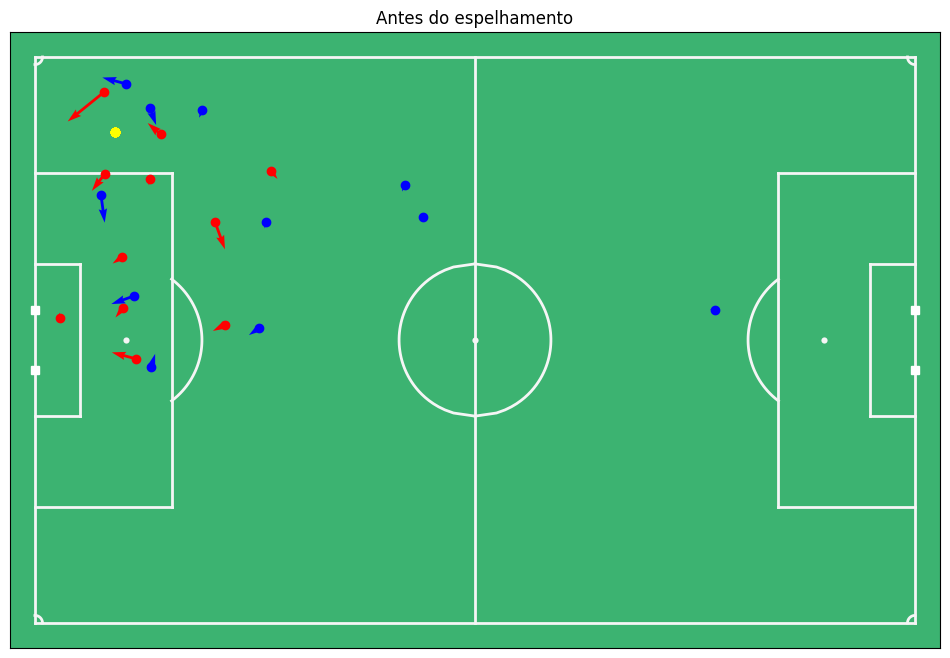

In [27]:
from utils import plot_pitch, to_home_away_team
import matplotlib.pyplot as plt

df_frame = df_original[(df_original["cross_id"] == 0) & (df_original["possession_type"] == "CROSS")]

df_home, df_away = to_home_away_team(df_frame)

fig, ax = plot_pitch()

plt.scatter(df_frame['ball_x'], df_frame['ball_y'], color='yellow', marker='o', zorder=5)

plt.scatter(df_home["x"], df_home["y"], color="red", zorder=5)
plt.quiver(df_home["x"], df_home["y"], df_home["vx_smooth"], df_home["vy_smooth"], color="red", angles='xy', scale_units='xy', scale=1, width=0.003, zorder=5)

plt.scatter(df_away["x"], df_away["y"], color="blue", zorder=5)
plt.quiver(df_away["x"], df_away["y"], df_away["vx_smooth"], df_away["vy_smooth"], color="blue", angles='xy', scale_units='xy', scale=1, width=0.003, zorder=5)
plt.title("Antes do espelhamento")

Text(0.5, 1.0, 'Após o espelhamento')

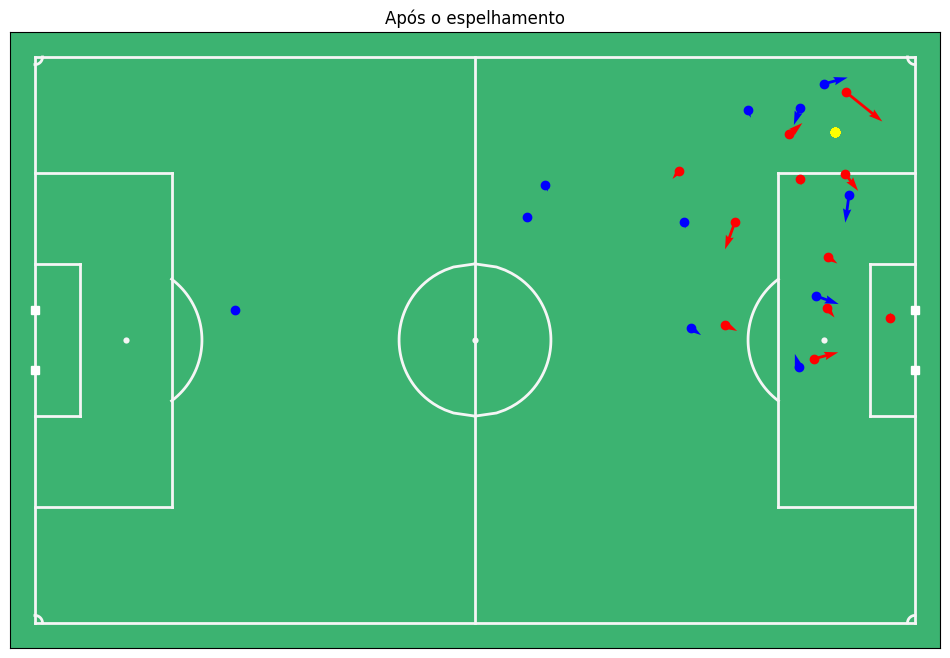

In [28]:
df_frame = df_frames[(df_frames["cross_id"] == 0) & (df_frames["possession_type"] == "CROSS")]

df_home, df_away = to_home_away_team(df_frame)

fig, ax = plot_pitch()

plt.scatter(df_frame['ball_x'], df_frame['ball_y'], color='yellow', marker='o', zorder=5)

plt.scatter(df_home["x"], df_home["y"], color="red", zorder=5)
plt.quiver(df_home["x"], df_home["y"], df_home["vx_smooth"], df_home["vy_smooth"], color="red", angles='xy', scale_units='xy', scale=1, width=0.003, zorder=5)

plt.scatter(df_away["x"], df_away["y"], color="blue", zorder=5)
plt.quiver(df_away["x"], df_away["y"], df_away["vx_smooth"], df_away["vy_smooth"], color="blue", angles='xy', scale_units='xy', scale=1, width=0.003, zorder=5)
plt.title("Após o espelhamento")

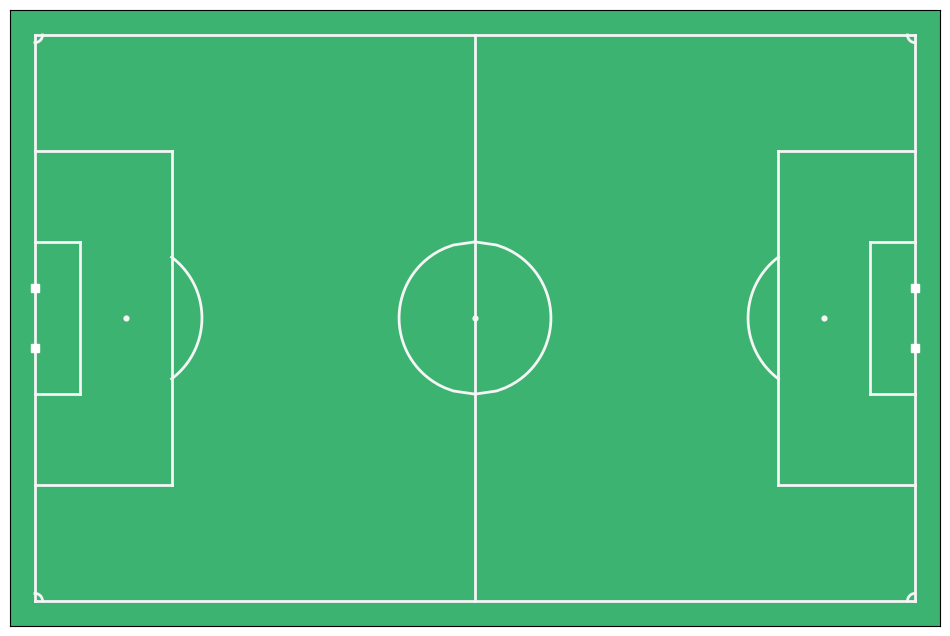

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from utils import plot_pitch, to_home_away_team

window_frames = df_frames[
    (df_frames["cross_id"] == 12) &
    (df_frames["vx"] != 0) &
    (df_frames["vy"] != 0)
]

unique_frame_ids = window_frames["frame_id"].unique()

fig, ax = plot_pitch()

ball_scatter = ax.scatter([], [], color='yellow', marker='o', zorder=5, s=80)
home_scatter = ax.scatter([], [], color='red', zorder=5)
away_scatter = ax.scatter([], [], color='blue', zorder=5)

home_quiver_obj = [None]
away_quiver_obj = [None]

def update(i):
    frame_id = unique_frame_ids[i]
    df_frame = window_frames[window_frames["frame_id"] == frame_id]
    df_home, df_away = to_home_away_team(df_frame)

    # Update posições dos jogadores e bola
    home_scatter.set_offsets(df_home[["x", "y"]].values)
    away_scatter.set_offsets(df_away[["x", "y"]].values)
    ball_pos = df_frame[["ball_x", "ball_y"]].dropna().values[:1]
    if len(ball_pos) > 0:
        ball_scatter.set_offsets(ball_pos)

    # Remove quivers antigos
    if home_quiver_obj[0]:
        home_quiver_obj[0].remove()
    if away_quiver_obj[0]:
        away_quiver_obj[0].remove()

    # Cria novos quivers
    home_quiver = ax.quiver(df_home["x"], df_home["y"],
                            df_home["vx_smooth"], df_home["vy_smooth"],
                            color="red", angles='xy', scale_units='xy', scale=1, width=0.003, zorder=5)
    away_quiver = ax.quiver(df_away["x"], df_away["y"],
                            df_away["vx_smooth"], df_away["vy_smooth"],
                            color="blue", angles='xy', scale_units='xy', scale=1, width=0.003, zorder=5)

    home_quiver_obj[0] = home_quiver
    away_quiver_obj[0] = away_quiver

    ax.set_title(f"Frame {frame_id}", fontsize=12)

    return home_scatter, away_scatter, ball_scatter

ani = FuncAnimation(fig, update, frames=len(unique_frame_ids), interval=50, blit=False)
plt.show()


from IPython.display import HTML
HTML(ani.to_jshtml())  # ou ani.to_html5_video()
